# Training the Classifiers
In this file, we will train our classifiers. We will first use the representations created using the GNN AutoEncoder (concept calues after applying the GNN AutoEncoder) to create a MNN Classifier and a Naive Bayes Classifier. Then we only use the embeddings (concept values before applying the GNN AutoEncoder) to create a MNN Classifier and a Naive Bayes Classifier.

### Importing the needed packages

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from models import RepMNNClassifier, EmbMNNClassifier
from utils import ConceptGraphDataset
import math
from random import randint, shuffle
import pandas as pd
import numpy as np
import joblib
import json
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score

In [2]:
cwd = os.getcwd()
path = os.path
pjoin = path.join
torch.manual_seed(12345)

In [3]:
dataset = ConceptGraphDataset(root=cwd)

mouse = []
human = []
for i in range(0, len(dataset)):
    data = dataset[i]
    ontology = data.ontology
    if ontology == 'human':
        human.append(data)
    elif ontology == 'mouse':
        mouse.append(data)
    else:
        raise Exception('Ontology Not Supported!')

In [4]:
ref = pd.read_csv(pjoin(cwd, 'data', 'ref.csv'), names=['mouse', 'human'], header=None)
label_data = {}
for index, row in ref.iterrows():
    label_data[f'{row["mouse"]}_{row["human"]}'] = 1
total_labels = 2 * len(label_data)
while(len(label_data) < total_labels):
    random_mouse_int = randint(0, (len(mouse)-1))
    random_human_int = randint(0, (len(human)-1))
    m_concept_id = mouse[random_mouse_int].mappings[0]
    h_concept_id = human[random_human_int].mappings[0]
    if f'{m_concept_id}_{random_human_int}' not in label_data:
        label_data[f'{m_concept_id}_{h_concept_id}'] = 0

In [5]:
dataset = [{'key': key, 'label': label_data[key]} for key in label_data]
shuffle(dataset)

In [6]:
class ConceptDataset(Dataset):
    def __init__(self, all_samples, is_emb=False):
        self.samples = all_samples
        self.is_emb = is_emb
        with open(pjoin(cwd, 'data', 'mouse.json'), "r") as file:
            self.m_concepts = json.loads(file.read())
        with open(pjoin(cwd, 'data', 'human.json'), "r") as file:
            self.h_concepts = json.loads(file.read())
 
    def __getitem__(self, idx):
        y = torch.tensor(self.samples[idx]['label'], dtype=torch.float32)
        concepts = self.samples[idx]['key'].split('_')
        if self.is_emb:
            m_concept = self.m_concepts[concepts[0]]
            m_concept = np.mean(m_concept['embed'], axis=0)
            h_concept = self.h_concepts[concepts[1]]
            h_concept = np.mean(h_concept['embed'], axis=0)
            x = torch.from_numpy(np.mean([m_concept, h_concept], axis=0)).float()
        else:
            m_rep = joblib.load(pjoin(cwd, 'data', 'representations', 'mouse', f'{concepts[0]}.pkl'))
            h_rep = joblib.load(pjoin(cwd, 'data', 'representations', 'human', f'{concepts[1]}.pkl'))
            x = torch.from_numpy(np.mean([m_rep, h_rep], axis=0)).float()
        
        return x, y
    
    def __len__(self):
        return len(self.samples)

In [7]:
def train(model, train_data, validation_data, train_device, num_epochs=400, batch_size=64, learning_rate=1e-3):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    correct = 0
    true_classes = []
    predicted_classes = []
    train_outputs = []
    validation_outputs = []
    for epoch in range(num_epochs):
        model.train()
        for i,(x_train, y_train) in enumerate(train_loader):
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            output = model(x_train)
            loss = criterion(output, y_train.reshape(-1,1))
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
            
            predicted_classes += output.reshape(-1).cpu().detach().numpy().round().tolist()
            true_classes += y_train.cpu().tolist()
            correct += int((torch.from_numpy(output.reshape(-1).cpu().detach().numpy().round()) == y_train.cpu()).sum())
        epoch_train_acc = correct/len(true_classes)
        val_corrects, val_true_classes, val_predicted_classes = test(model, validation_data, train_device, batch_size=batch_size)
        epoch_val_acc = val_corrects/len(val_true_classes)
        train_outputs.append(epoch_train_acc)
        validation_outputs.append(epoch_val_acc)
        if ((epoch+1) % 10) == 0:
            epoch_info = ' Epoch:{}, Training Acc:{:.4f}, Validation Acc:{:.4f} '.format(epoch+1, epoch_train_acc, epoch_val_acc)
            print(epoch_info.center(len(epoch_info) + 20, '='))
    return train_outputs, validation_outputs, predicted_classes, true_classes

In [8]:
def test(model, test_data, test_device, batch_size=64):
    model.eval()

    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    correct = 0
    true_classes = []
    predicted_classes = []
    for i,(x_test, y_test) in enumerate(test_loader):
        x_test = x_test.to(test_device)
        y_test = y_test.to(test_device)
        output = model(x_test)
        predicted_classes += output.reshape(-1).cpu().detach().numpy().round().tolist()
        true_classes += y_test.cpu().tolist()
        correct += int((torch.from_numpy(output.reshape(-1).cpu().detach().numpy().round()) == y_test.cpu()).sum()) 
    return correct, true_classes, predicted_classes

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch = 64
epochs = 400

print(f'Training will be done on {device}')

Training will be done on cuda:0


## Training Using Representations

In [10]:
train_size = math.ceil(len(dataset) *0.7)
all_train = dataset[:train_size]
train_split = math.ceil(len(all_train) * 0.7)

train_data = all_train[:train_split]
validation_data = all_train[train_split:]
test_data = dataset[train_size:]

#DataLoader
train_set = ConceptDataset(train_data, is_emb=False)
validation_set = ConceptDataset(validation_data, is_emb=False)
test_set = ConceptDataset(test_data, is_emb=False)

### Training the MNN Classifier to use the representations

In [11]:
rep_model = RepMNNClassifier()
rep_model = rep_model.to(device)
print(rep_model)

RepMNNClassifier(
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)


In [12]:
rep_train_outputs, rep_validation_outputs, rep_predicted_classes, rep_true_classes = train(rep_model, train_set, validation_set, device, num_epochs=epochs, batch_size=batch)
rep_val_correct, rep_val_true_classes, rep_val_predicted_classes = test(rep_model, validation_set, device, batch_size=batch)

========== Epoch:10, Training Acc:0.5976, Validation Acc:0.7044 ==========
========== Epoch:20, Training Acc:0.6844, Validation Acc:0.7594 ==========
========== Epoch:30, Training Acc:0.7351, Validation Acc:0.7925 ==========
========== Epoch:40, Training Acc:0.7669, Validation Acc:0.8050 ==========
========== Epoch:50, Training Acc:0.7887, Validation Acc:0.8160 ==========
========== Epoch:60, Training Acc:0.8056, Validation Acc:0.8223 ==========
========== Epoch:70, Training Acc:0.8196, Validation Acc:0.8349 ==========
========== Epoch:80, Training Acc:0.8320, Validation Acc:0.8381 ==========
========== Epoch:90, Training Acc:0.8422, Validation Acc:0.8365 ==========
========== Epoch:100, Training Acc:0.8513, Validation Acc:0.8333 ==========
========== Epoch:110, Training Acc:0.8593, Validation Acc:0.8349 ==========
========== Epoch:120, Training Acc:0.8666, Validation Acc:0.8365 ==========
========== Epoch:130, Training Acc:0.8732, Validation Acc:0.8365 ==========
========== Epoch:140,

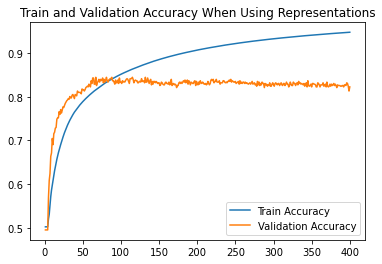

In [13]:
epochs_list = range(1, epochs+1)
plt.plot(epochs_list, rep_train_outputs, label = "Train Accuracy")
plt.plot(epochs_list, rep_validation_outputs, label = "Validation Accuracy")
plt.title("Train and Validation Accuracy When Using Representations")
plt.legend()
plt.savefig(pjoin(cwd, 'data', 'rep_classification_train_validation_accuracy'))
plt.show()

In [14]:
rep_test_correct, rep_test_true_classes, rep_test_predicted_classes = test(rep_model, test_set, device, batch_size=batch)
print(f'Test Accuracy: {(rep_test_correct/len(rep_test_true_classes))*100}%')
print(classification_report(rep_test_true_classes, rep_test_predicted_classes, target_names=['Aligned', 'Not Aligned']))

Test Accuracy: 86.90869086908691%
              precision    recall  f1-score   support

     Aligned       0.88      0.85      0.87       455
 Not Aligned       0.86      0.88      0.87       454

    accuracy                           0.87       909
   macro avg       0.87      0.87      0.87       909
weighted avg       0.87      0.87      0.87       909



### NB Classifier

In [15]:
with open(pjoin(cwd, 'data', 'mouse.json'), "r") as file:
    m_concepts = json.loads(file.read())
with open(pjoin(cwd, 'data', 'human.json'), "r") as file:
    h_concepts = json.loads(file.read())

    
X = []
y = []
for data in dataset:
    concepts = data['key'].split('_')
    m_rep = joblib.load(pjoin(cwd, 'data', 'representations', 'mouse', f'{concepts[0]}.pkl'))
    h_rep = joblib.load(pjoin(cwd, 'data', 'representations', 'human', f'{concepts[1]}.pkl'))
    X.append(np.mean([m_rep, h_rep], axis=0))
    y.append(data['label'])

rep_X_train, rep_X_test, rep_y_train, rep_y_test = train_test_split(np.array(X), np.array(y), test_size=0.7, random_state=1234)
rep_gnb = GaussianNB()
rep_y_pred = rep_gnb.fit(rep_X_train, rep_y_train).predict(rep_X_test)
print(f'Accuracy: {((rep_y_test == rep_y_pred).sum()/rep_X_test.shape[0])*100}%')
print(classification_report(rep_y_pred, rep_y_test, labels=[0, 1], target_names=['Not Aligned', 'Aligned']))

Accuracy: 84.55016486104569%
              precision    recall  f1-score   support

 Not Aligned       0.87      0.82      0.85      1094
     Aligned       0.82      0.87      0.84      1029

    accuracy                           0.85      2123
   macro avg       0.85      0.85      0.85      2123
weighted avg       0.85      0.85      0.85      2123



## Training the MNN Classifier Using Embeddings

In [16]:
#DataLoader
train_set = ConceptDataset(train_data, is_emb=True)
validation_set = ConceptDataset(validation_data, is_emb=True)
test_set = ConceptDataset(test_data, is_emb=True)

In [17]:
emb_model = EmbMNNClassifier()
emb_model = emb_model.to(device)
print(emb_model)

EmbMNNClassifier(
  (fc1): Linear(in_features=200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [18]:
emb_train_outputs, emb_validation_outputs, emb_predicted_classes, emb_true_classes = train(emb_model, train_set, validation_set, device, num_epochs=epochs, batch_size=batch)
emb_val_correct, emb_val_true_classes, emb_val_predicted_classes = test(emb_model, validation_set, device, batch_size=batch)

========== Epoch:10, Training Acc:0.7229, Validation Acc:0.8050 ==========
========== Epoch:20, Training Acc:0.8241, Validation Acc:0.8491 ==========
========== Epoch:30, Training Acc:0.8753, Validation Acc:0.8538 ==========
========== Epoch:40, Training Acc:0.9049, Validation Acc:0.8679 ==========
========== Epoch:50, Training Acc:0.9234, Validation Acc:0.8711 ==========
========== Epoch:60, Training Acc:0.9358, Validation Acc:0.8648 ==========
========== Epoch:70, Training Acc:0.9448, Validation Acc:0.8742 ==========
========== Epoch:80, Training Acc:0.9516, Validation Acc:0.8789 ==========
========== Epoch:90, Training Acc:0.9568, Validation Acc:0.8758 ==========
========== Epoch:100, Training Acc:0.9609, Validation Acc:0.8758 ==========
========== Epoch:110, Training Acc:0.9644, Validation Acc:0.8805 ==========
========== Epoch:120, Training Acc:0.9672, Validation Acc:0.8774 ==========
========== Epoch:130, Training Acc:0.9697, Validation Acc:0.8742 ==========
========== Epoch:140,

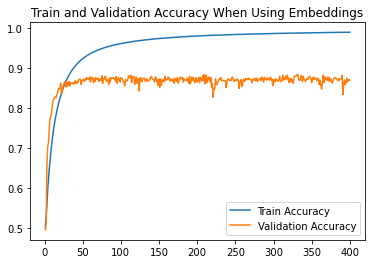

In [19]:
epochs_list = range(1, epochs+1)
plt.plot(epochs_list, emb_train_outputs, label = "Train Accuracy")
plt.plot(epochs_list, emb_validation_outputs, label = "Validation Accuracy")
plt.title("Train and Validation Accuracy When Using Embeddings")
plt.legend()
plt.savefig(pjoin(cwd, 'data', 'emb_classification_train_validation_accuracy'))
plt.show()

In [20]:
emb_test_correct, emb_test_true_classes, emb_test_predicted_classes = test(emb_model, test_set, device, batch_size=batch)
print(f'Test Accuracy: {(emb_test_correct/len(emb_test_true_classes))*100}%')
print(classification_report(emb_test_true_classes, emb_test_predicted_classes, labels=[0, 1], target_names=['Not Aligned', 'Aligned']))

Test Accuracy: 86.35863586358636%
              precision    recall  f1-score   support

 Not Aligned       0.85      0.88      0.87       455
     Aligned       0.88      0.85      0.86       454

    accuracy                           0.86       909
   macro avg       0.86      0.86      0.86       909
weighted avg       0.86      0.86      0.86       909



### NB Classifier

In [21]:
X = []
y = []
for data in dataset:
    concepts = data['key'].split('_')
    m_rep = joblib.load(pjoin(cwd, 'data', 'representations', 'mouse', f'{concepts[0]}.pkl'))
    h_rep = joblib.load(pjoin(cwd, 'data', 'representations', 'human', f'{concepts[1]}.pkl'))
    m_concept = m_concepts[concepts[0]]
    m_concept = np.mean(m_concept['embed'], axis=0)
    h_concept = h_concepts[concepts[1]]
    h_concept = np.mean(h_concept['embed'], axis=0)
    X.append(np.mean([m_concept, h_concept], axis=0))
    y.append(data['label'])

emd_X_train, emd_X_test, emd_y_train, emd_y_test = train_test_split(np.array(X), np.array(y), test_size=0.7, random_state=1234)
emb_gnb = GaussianNB()
emd_y_pred = emb_gnb.fit(emd_X_train, emd_y_train).predict(emd_X_test)
print(f'Accuracy: {((emd_y_test == emd_y_pred).sum()/emd_X_test.shape[0])*100}%')
print(classification_report(emd_y_pred, emd_y_test, labels=[0, 1], target_names=['Not Aligned', 'Aligned']))

Accuracy: 84.22044276966557%
              precision    recall  f1-score   support

 Not Aligned       0.88      0.81      0.85      1131
     Aligned       0.80      0.88      0.84       992

    accuracy                           0.84      2123
   macro avg       0.84      0.84      0.84      2123
weighted avg       0.85      0.84      0.84      2123



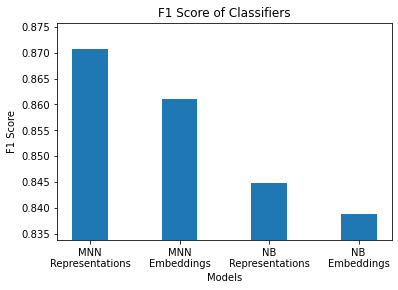

In [22]:
rep_mnn_f1 = f1_score(rep_test_true_classes, rep_test_predicted_classes)
emb_mnn_f1 = f1_score(emb_test_true_classes, emb_test_predicted_classes)
rep_nb_f1 = f1_score(rep_y_test, rep_y_pred)
emb_nb_f1 = f1_score(emd_y_test, emd_y_pred)

x_bar = ['MNN\nRepresentations','MNN\nEmbeddings','NB\nRepresentations','NB\nEmbeddings']
y_bar = [rep_mnn_f1, emb_mnn_f1, rep_nb_f1, emb_nb_f1]
  
X_axis = np.arange(len(x_bar))
  
plt.bar(x_bar, y_bar, 0.4)
plt.ylim(top=(max(y_bar)+0.005))
plt.ylim(bottom=(min(y_bar)-0.005))
plt.xticks(X_axis, x_bar)
plt.xlabel("Models")
plt.ylabel("F1 Score")
plt.title("F1 Score of Classifiers")
plt.savefig(pjoin(cwd, 'data', 'classifiers_f1_score_Comparison'))
plt.show()

## Using Cosine Similarity

In [23]:
from sklearn.metrics import auc

def roc_eval(data, sim_type):
    datamat = pd.read_csv(pjoin(cwd, 'data', f'{sim_type}_similarity.csv'), index_col=0)
    fpr_list = []
    tpr_list = []
    
    total_pairs = data
    total_pairs_len = len(total_pairs)
    data_values = list(data.values())
    ref_row_count = data_values.count(1)
    for threshold in np.arange(0, 1, 0.1):    
        tp = 0
        fp = 0
        for pair in total_pairs:
            col, ind = pair.split('_')
            sim = datamat.loc[ind][col]
            if sim >= threshold:
                if data[pair] == 1:
                    tp += 1
                else: 
                    fp += 1

        negatives = total_pairs_len - ref_row_count
        tn = negatives - fp
        fn = ref_row_count - tp
        fpr_list.append(fp / negatives)
        tpr_list.append(tp / ref_row_count)
        

    area = auc(fpr_list,tpr_list)
    best_threshold = np.arange(0, 1, 0.1)[np.argmax(np.abs(np.array(fpr_list) - np.array(tpr_list)))]
    fpr_list.insert(0,1)
    tpr_list.insert(0,1)
    fpr_list.append(0)
    tpr_list.append(0)
    plt.figure()
    plt.plot(fpr_list, tpr_list, color='darkorange', marker='.', lw=2, label="AUC="+str(area))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title('ROC Curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    plt.savefig(pjoin(cwd, 'data', f'{sim_type}_roc.png'))
    
    pred_values = []
    for pair in total_pairs:
        col, ind = pair.split('_')
        sim = datamat.loc[ind][col]
        if sim >= best_threshold:
            pred_values.append(1)
        else:
            pred_values.append(0)

    return pred_values

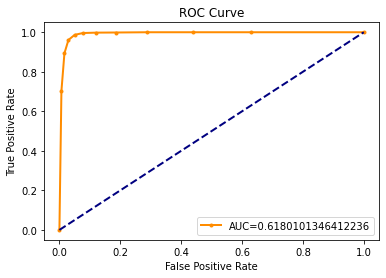

<Figure size 432x288 with 0 Axes>

In [24]:
true_values = [label_data[key] for key in label_data]
rep_sim_pred_values = roc_eval(label_data, 'representations')

### Using Representations Consine Similarity

In [25]:
print(classification_report(rep_sim_pred_values, true_values, labels=[0, 1], target_names=['Not Aligned', 'Aligned']))

              precision    recall  f1-score   support

 Not Aligned       0.95      0.99      0.97      1460
     Aligned       0.99      0.95      0.97      1572

    accuracy                           0.97      3032
   macro avg       0.97      0.97      0.97      3032
weighted avg       0.97      0.97      0.97      3032



### Using Embeddings Cosine Similarity

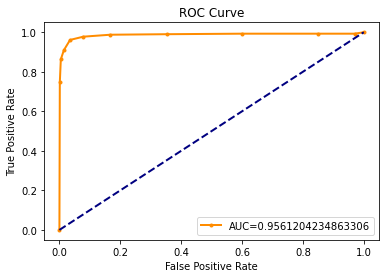

<Figure size 432x288 with 0 Axes>

In [26]:
emb_sim_pred_values = roc_eval(label_data, 'embeddings')

In [27]:
print(classification_report(emb_sim_pred_values, true_values, labels=[0, 1], target_names=['Not Aligned', 'Aligned']))

              precision    recall  f1-score   support

 Not Aligned       0.97      0.96      0.96      1522
     Aligned       0.96      0.96      0.96      1510

    accuracy                           0.96      3032
   macro avg       0.96      0.96      0.96      3032
weighted avg       0.96      0.96      0.96      3032



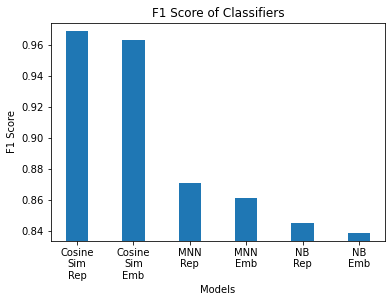

In [32]:
rep_mnn_f1 = f1_score(rep_test_true_classes, rep_test_predicted_classes)
emb_mnn_f1 = f1_score(emb_test_true_classes, emb_test_predicted_classes)
rep_nb_f1 = f1_score(rep_y_test, rep_y_pred)
emb_nb_f1 = f1_score(emd_y_test, emd_y_pred)
rep_sim_f1 = f1_score(true_values, rep_sim_pred_values)
emb_sim_f1 = f1_score(true_values, emb_sim_pred_values)

x_bar = ['Cosine\nSim\nRep', 'Cosine\nSim\nEmb', 'MNN\nRep','MNN\nEmb','NB\nRep','NB\nEmb']
y_bar = [rep_sim_f1, emb_sim_f1, rep_mnn_f1, emb_mnn_f1, rep_nb_f1, emb_nb_f1]
  
X_axis = np.arange(len(x_bar))
  
plt.bar(x_bar, y_bar, 0.4)
plt.ylim(top=(max(y_bar)+0.005))
plt.ylim(bottom=(min(y_bar)-0.005))
plt.xticks(X_axis, x_bar)
plt.xlabel("Models")
plt.ylabel("F1 Score")
plt.title("F1 Score of Classifiers")
plt.savefig(pjoin(cwd, 'data', 'methods_f1_score_comparison'))
plt.show()

## Conclusion
Based on the results above, using the representations, we achieve a better performance (f1-score) when classifying using the Naive Bayes Classifier. For the MNN Classifier, when using the representations, the model has a slight improvement in performance (f1-score). For the Cosine Similarity method, when using the representations, the model has a better performance (f1-score).

We can say using the GNN AutoEncoder to first create the representations can be helpful in the ontology alignment process, not only it reduces the dimensions, but also when creating the representations, the structural dependencies between the concepts were taken into account.